# Simulate/fit/analyze in batch mode

## Generate observed binary properties

In [1]:
import numpy as np

from isochrones import get_ichrone

bands = ['J', 'H', 'K', 'G', 'BP', 'RP']
mist = get_ichrone('mist', bands=bands)

In [2]:
from itertools import product

primary_masses = [0.8, 1.0]
mass_ratios = [0.5, 0.9]
feh_grid = [-0.25, 0.0]
age = 9.7
distance = 500
AV = 0.

m1, m2, feh, name = zip(*[(m, q*m, f, f'{m:.2f}_{q*m:0.2f}_{f:0.2f}') 
                          for m, q, f 
                          in product(primary_masses, mass_ratios, feh_grid)])

df = mist.generate_binary(m1, m2, age, feh, distance=distance, AV=AV, accurate=True)

# add uncertainties for each band

uncs = {'J': 0.02, 'H': 0.02, 'K':0.02, 'G': 0.002, 'BP': 0.002, 'RP':0.002}

for b in bands:
    df[f'{b}_mag_unc'] = uncs[b]
    
# Add parallax & uncertainty
df['parallax'] = 1000/distance
df['parallax_unc'] = 0.02
df.index = name

## Use a StarCatalog to organize data

In [3]:
from isochrones.catalog import StarCatalog
from isochrones.priors import FlatPrior

catalog = StarCatalog(df, bands=bands, props=['parallax'])
catalog.set_prior(AV=FlatPrior((0, 0.0001)), age=FlatPrior((8.5, 10)))

## Fit models

Here is a snippet to fit all the models (using the convenient `.iter_models()` API); this could easily be adapted into a cluster script (e.g., using `schwimmbad`) to run thousands of fits.

In [4]:
from multiprocessing import Pool

def fit_model(mod):
    print(mod.mnest_basename)
    mod.fit(verbose=True)
    return mod.derived_samples

pool = Pool(processes=8)  # e.g.

samples = pool.map(fit_model, catalog.iter_models(N=2))

./chains/0.80_0.40_0.00-mist-binary-
./chains/0.80_0.72_-0.25-mist-binary-
./chains/0.80_0.40_-0.25-mist-binary-
./chains/0.80_0.72_0.00-mist-binary-
./chains/1.00_0.90_-0.25-mist-binary-
./chains/1.00_0.50_0.00-mist-binary-
./chains/1.00_0.50_-0.25-mist-binary-
./chains/1.00_0.90_0.00-mist-binary-


## Analyze samples

A `StarCatalog` could probably have some convenience methods for some of this stuff, but this for now.

In [5]:
cols = ['mass_0', 'mass_1', 'age', 'feh', 'AV']
qs = [0.05, 0.16, 0.5, 0.84, 0.95]
for name, samps in zip(catalog.df.index, samples):
    print(name)
    print(samps[cols].quantile(qs))

0.80_0.40_-0.25
        mass_0    mass_1       age       feh        AV
0.05  0.788509  0.164104  8.590132 -0.293850  0.000006
0.16  0.805008  0.228368  8.743714 -0.253675  0.000017
0.50  0.833366  0.340758  9.247066 -0.190112  0.000048
0.84  0.855241  0.416302  9.773557 -0.131899  0.000083
0.95  0.866117  0.449012  9.897167 -0.094858  0.000094
0.80_0.40_0.00
        mass_0    mass_1       age       feh        AV
0.05  0.784659  0.246191  8.593086 -0.120908  0.000006
0.16  0.797947  0.298331  8.766900 -0.062426  0.000016
0.50  0.819930  0.376510  9.276954  0.009771  0.000049
0.84  0.840262  0.449128  9.795532  0.071350  0.000083
0.95  0.851633  0.484547  9.930719  0.106657  0.000094
0.80_0.72_-0.25
        mass_0    mass_1       age       feh        AV
0.05  0.823122  0.570798  8.556728 -0.238374  0.000006
0.16  0.864137  0.610448  8.685393 -0.160716  0.000017
0.50  0.915067  0.663009  9.070065  0.011863  0.000050
0.84  0.955065  0.719841  9.563513  0.119402  0.000083
0.95  0.972557  0.

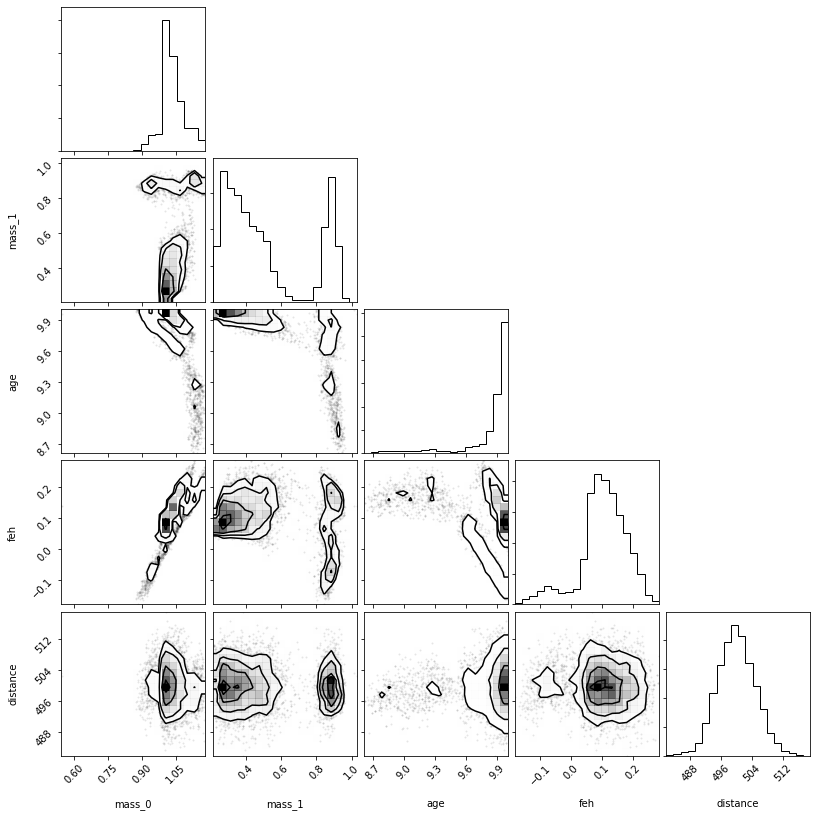

In [6]:
from corner import corner

corner(samples[-1][['mass_0', 'mass_1', 'age', 'feh', 'distance']]);

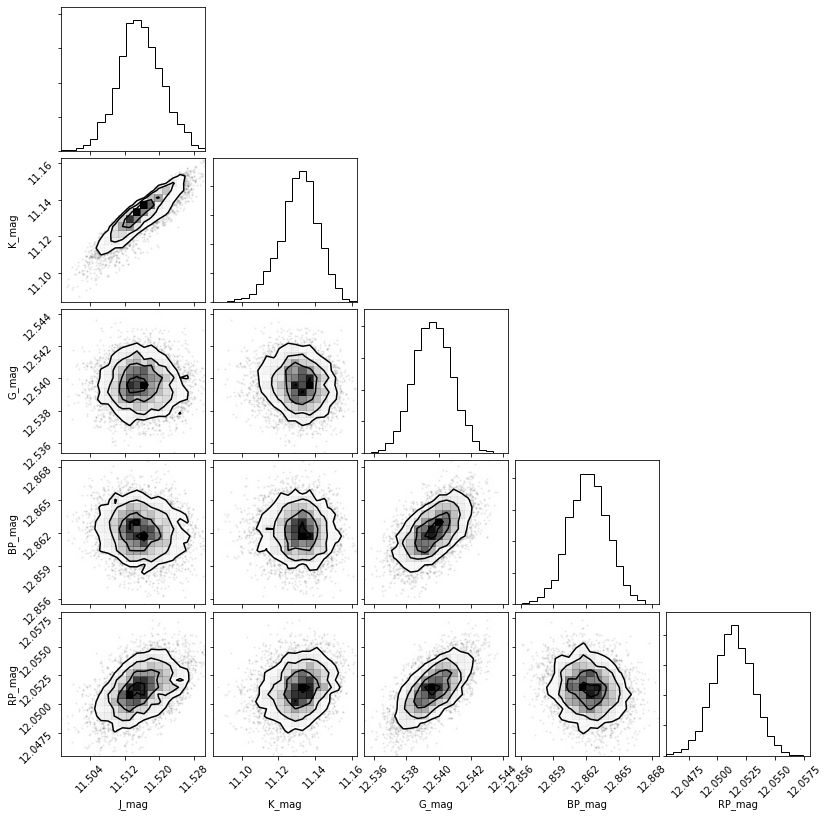

In [7]:
corner(samples[-1][['J_mag', 'K_mag', 'G_mag', 'BP_mag', 'RP_mag']]);